In this project I will explore how to develop a simple Convolutional Neural Network for image classification. I will use the CIFAR-10 dataset. In the first part, I will show how to develop a simple CNN, while in the second part I will explore the impact of various hyper-parameters on the learning performances.

In [1]:
# They've just released torch 2.0, but we will use the more stable torch=1.13 along with other supporting libriaries
!pip3 install pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 81.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchdata to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 109.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 97.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchtext to determine which version is compatible with other requirements. This c

In [2]:
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Linear
from torchinfo import summary
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Lambda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore") #Conflict of nn.functional.act_f and torch.act_f

print(f"{torch.__version__=}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
!nvidia-smi --format=csv --query-gpu=index,name,driver_version,memory.total,memory.used,memory.free

# Set seed for reproducibility
torch.manual_seed(43)
rng = np.random.default_rng(seed=4242)

torch.__version__='1.13.1+cu117'
device=device(type='cuda')
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, Tesla T4, 525.105.17, 15360 MiB, 3 MiB, 15098 MiB


## Data Loading and Preprocessing


I will use the `CIFAR-10` dataset.The dataset consists of $60.000$ images in $10$ classes, with $6.000$ images per class. There are $50.000$ training images and $10.000$ test images. Each sample is a $32\times32$ pixels color image (thus with an extra $\times3$ dimensions for the colors channels), associated with a label from one of the classes:

```python
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
```

I will divide the dataset in training, testing and validation set. The training set will be used to train the model, the validation set will be used to perform model selection and finally, the test set will be used to asses the performance of deep network.

In the standard dataset, each pixel intensity is represented by a `uint8` (byte) from $0$ to $255$. As a preprocessing step, we will rescale these values in the range $[0,1]$. You should write a simple so-called MinMaxScaler which takes as input a PIL Image (a specific format for images in Python) and rescales it, after making the appropriate type and shape transformations.

In [3]:
def MinMaxScaler(img):
  # First, I load the data as numpy array
  img_as_array = np.asarray(img)
  # Transform the array to Tensor for PyTorch
  img_as_tensor = torch.from_numpy(img_as_array)
  # Image is of size (Height, Width, Channels). But torch excepts (C, H, W). Hence, the second thing is to permute.
  img_as_tensor = img_as_tensor.permute(2, 0, 1)
  # Rescale image pixels form [0,255] to [0,1]
  normalized_img = img_as_tensor / 255.0
  return normalized_img


'''
NEW DATA LOADING
Note that the previous function must be passed to transforms.Lambda().
'''
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(MinMaxScaler)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(MinMaxScaler)) # 10000 samples

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [4]:
# Let's check the classes and dataset shapes:
classes = dataset.classes
print(f"{classes=}")
print(f"Dataset shape: {dataset.data.shape}")
print(f"Test set shape: {test_data.data.shape}")

classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Dataset shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [5]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Lambda()

In [6]:
# Let's also check whether the dataset is balanced, i.e. there are the same amount of samples for each class
label_count = {}
for _, idx in dataset:
    label = classes[idx]
    if label not in label_count:
        label_count[label] = 0
    label_count[label] += 1
label_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

I split the dataset into training/validation sets:

In [7]:
val_size = 5000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 45000 
Validation samples = 5000 
Test samples = 10000


In [8]:
idx = 50 # 51st data sample
print(train_data[idx]) # (image, label) tensors
assert train_data[idx][0].max().item() <= 1., "Check your MinMaxScaler!"

(tensor([[[0.7373, 0.7216, 0.7255,  ..., 0.7922, 0.7922, 0.7882],
         [0.7216, 0.7059, 0.7137,  ..., 0.7765, 0.7725, 0.7725],
         [0.7373, 0.7255, 0.7216,  ..., 0.7569, 0.7529, 0.7490],
         ...,
         [0.7608, 0.7608, 0.7647,  ..., 0.7647, 0.7765, 0.7686],
         [0.8039, 0.8000, 0.8039,  ..., 0.8157, 0.8157, 0.8000],
         [0.8235, 0.8157, 0.8157,  ..., 0.7922, 0.8000, 0.7804]],

        [[0.6902, 0.6784, 0.6824,  ..., 0.7490, 0.7490, 0.7451],
         [0.6784, 0.6627, 0.6706,  ..., 0.7333, 0.7294, 0.7294],
         [0.6941, 0.6824, 0.6784,  ..., 0.7137, 0.7098, 0.7059],
         ...,
         [0.7137, 0.7098, 0.7137,  ..., 0.7137, 0.7255, 0.7176],
         [0.7569, 0.7569, 0.7608,  ..., 0.7725, 0.7725, 0.7569],
         [0.7804, 0.7725, 0.7725,  ..., 0.7490, 0.7569, 0.7373]],

        [[0.6745, 0.6627, 0.6667,  ..., 0.7333, 0.7333, 0.7294],
         [0.6588, 0.6471, 0.6549,  ..., 0.7176, 0.7137, 0.7137],
         [0.6784, 0.6667, 0.6627,  ..., 0.6980, 0.6941, 0

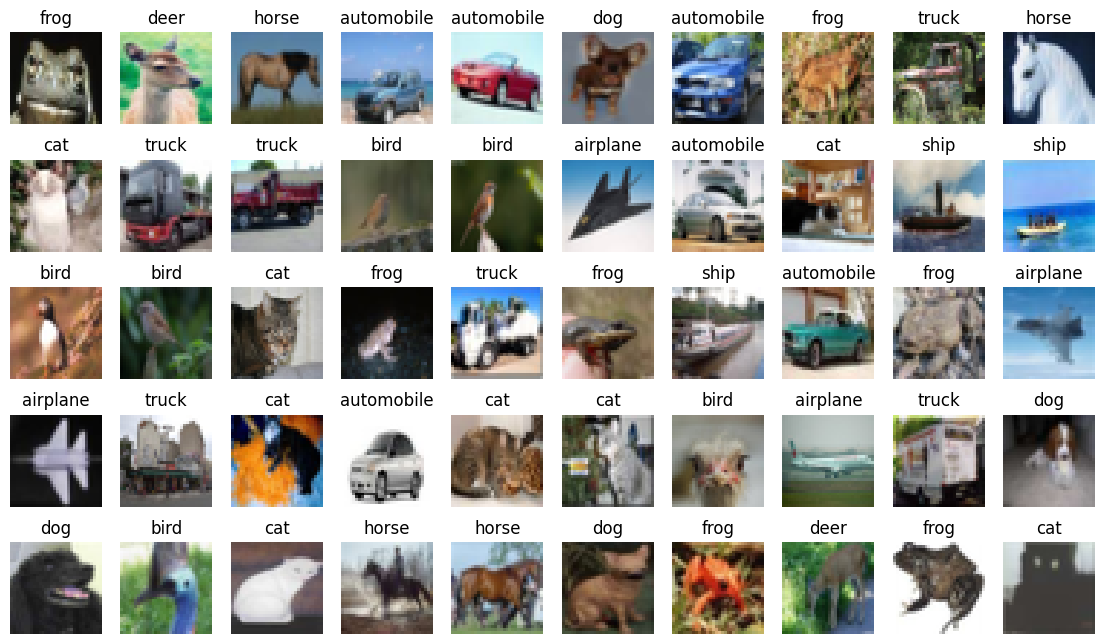

In [9]:
img_chan, img_height, img_width = train_data[idx][0].shape #Channel, Height, Width

# Plots
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, label = train_data[index]
        image = image.permute((1, 2, 0)) #C,H,W -> H,W,C
        plt.imshow(image, cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(classes[label])
plt.show()

Since `train_data`, `val_data` and `test_data` are already PyTorch Datasets, we can use directly DataLoaders to load data from them.

In [10]:
batch_size = 256
dataloader_training = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_data, batch_size=batch_size)
dataloader_test = DataLoader(test_data, batch_size=batch_size)

##Model Definition and Training

Let's create a simple CNN. The model will be composed of:
* One 2D convolutional layer with kernel size 3x3 and 32 output filters/features, that use ReLU activation function
* a Max Pooling layer (2D) of size 2x2.
* a Flatten layer
* a final Dense layer with 10 output neurons (one per class). I do not need to normalize or transform further the outputs, as the `CrossEntropyLoss` takes care of that. Another equivalent approach would be to add a `LogSoftmax` final layer that returns log-probabilities and then use the `NegativeLogLikelihoodLoss`., and with the _softmax_ activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.

In [11]:
class My_Convolutional_Network(nn.Module):
  def __init__(self, conv_filters=[], kernel_sizes=[], max_pool_sizes=[], act_fs=[], verbose=False):
    super().__init__()

    assert len(conv_filters) == len(kernel_sizes), "length of {conv_filters} and {kernel_sizes} must be same"
    assert len(conv_filters) == len(max_pool_sizes), "length of {conv_filters} and {max_pool_sizes} must be same"
    # max pool of [1, 1] corresponds to no max pool
    assert len(conv_filters) == len(act_fs), "length of {conv_filters} and {act_fs} must be same"

    self.conv_layers = nn.ModuleList()
    self.max_pools = nn.ModuleList()
    self.in_chan = img_chan
    self.in_height = img_height
    self.in_width = img_width
    self.output_dim = len(classes)#10
    self.verbose = verbose
    self.act_fs = act_fs

    height_dimension = self.in_height
    width_dimension = self.in_width

    for maxp1, maxp2 in max_pool_sizes: # as long as padding='same'
      height_dimension = height_dimension // maxp1
      width_dimension = width_dimension // maxp2

    self.inp_dim_to_linear = conv_filters[-1] * height_dimension * width_dimension

    for idx in range(len(conv_filters)):
      if idx == 0:
        #Conv2d(in_channels, out_channels, kernel_size, padding)
        self.conv_layers = self.conv_layers.append(Conv2d(self.in_chan, conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))
      else:
        self.conv_layers = self.conv_layers.append(Conv2d(conv_filters[idx-1], conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))

      self.max_pools = self.max_pools.append(MaxPool2d(max_pool_sizes[idx]))

    self.linear = Linear(self.inp_dim_to_linear, self.output_dim)

  def forward(self, x):

    for idx in range(len(self.conv_layers)):
      from_shape = x.shape[1:]
      active_conv_layer = self.conv_layers[idx]
      active_max_pool = self.max_pools[idx]
      active_act_fun = self.act_fs[idx]
      x = active_max_pool(active_act_fun(active_conv_layer(x)))
      to_shape = x.shape[1:]

      if self.verbose:
        print(f'From dimension [{from_shape}] to dimension [{to_shape}]')

    x = torch.flatten(x, start_dim=1) #if start_dim=1 missed, it also consider batch_size

    if self.verbose:
        print(f'From dimension [{to_shape}] to dimension [{x.shape[1:]}]')
        print(f'From dimension [{x.shape[1:]}] to dimension [{self.output_dim}]')

    return self.linear(x) #no need to use softmax because of the loss function

In [13]:
conv_filters = [32]
kernel_sizes = [[3, 3]]
max_pool_sizes = [[2, 2]]
act_fs = [F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-2                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─Linear: 1-3                            [256, 10]                 81,930
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
Total mult-adds (M): 255.86
Input size (MB): 3.15
Forward/backward pass size (MB): 67.13
Params size (MB): 0.33
Estimated Total Size (MB): 70.61

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (img, label) in enumerate(dataloader_train):
      img, label = img.to(device), label.to(device)
      optimizer.zero_grad()
      logits = model(img)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (img, label) in enumerate(dataloader_val):
            img, label = img.to(device), label.to(device)
            logits = model(img)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [16]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 38.93%, Loss: 1.74445510 ---------------- Val_Acc: 44.80%, Val_Loss: 1.56729162
epoch: 2 -> Accuracy: 50.49%, Loss: 1.43174648 ---------------- Val_Acc: 50.98%, Val_Loss: 1.40316963
epoch: 3 -> Accuracy: 54.53%, Loss: 1.31369758 ---------------- Val_Acc: 54.30%, Val_Loss: 1.31553233
epoch: 4 -> Accuracy: 57.81%, Loss: 1.23205948 ---------------- Val_Acc: 55.36%, Val_Loss: 1.27001238
epoch: 5 -> Accuracy: 59.79%, Loss: 1.17339230 ---------------- Val_Acc: 57.04%, Val_Loss: 1.22905076
epoch: 6 -> Accuracy: 61.36%, Loss: 1.12230420 ---------------- Val_Acc: 58.74%, Val_Loss: 1.18909287
epoch: 7 -> Accuracy: 62.79%, Loss: 1.08729494 ---------------- Val_Acc: 59.64%, Val_Loss: 1.17404485
epoch: 8 -> Accuracy: 63.85%, Loss: 1.05756533 ---------------- Val_Acc: 60.24%, Val_Loss: 1.14952385
epoch: 9 -> Accuracy: 64.81%, Loss: 1.03116691 ---------------- Val_Acc: 60.20%, Val_Loss: 1.14979887
epoch: 10 -> Accuracy: 65.43%, Loss: 1.01016390 ---------------- Val_Acc: 60.34%, 

In [17]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(num_epochs), acc_tr, label='acc_training')
    plt.plot(range(num_epochs), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(num_epochs), loss_tr, label='loss_training')
    plt.plot(range(num_epochs), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

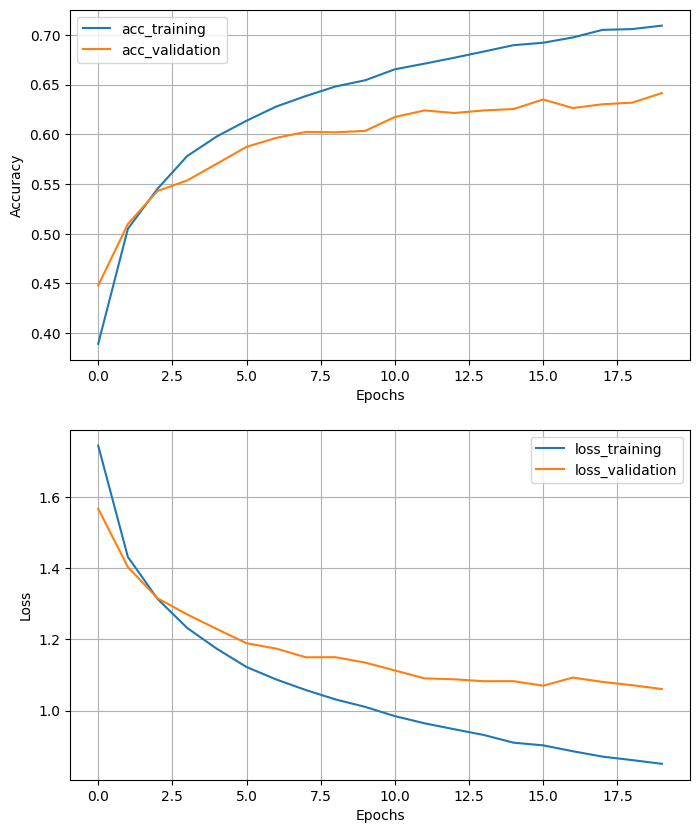

In [18]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

Finally, we test the model:

In [19]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (img, label) in enumerate(dataloader_test):
      img, label = img.to(device), label.to(device)
      logits = model(img)
      loss += criterion(logits, label)
      total_acc_test += (logits.argmax(1) == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [20]:
test(model)

Test Loss: 1.03837991 ---------- Test Accuracy: 64.1600%


Here we see that the test accuracy of our simple CNN is about 64%.

## Visualize filters
Let's now visualize the filters emerged in the first convolutional layer.

In [21]:
layer_names = []
weights = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        layer_names.append(name)
        weights.setdefault(name, param.data)

conv_weights = weights['conv_layers.0.weight']
print(f"{conv_weights.shape=} <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]")

conv_weights.shape=torch.Size([32, 3, 3, 3]) <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]


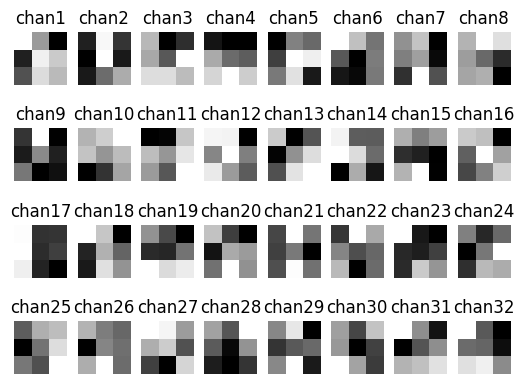

In [22]:
conv_w0 = conv_weights[:, 0, :, :] # Pick one input dimension

# Rescale weights for visualization
conv_w0 -= torch.min(conv_w0)
conv_w0 /= torch.max(conv_w0)

for r in range(4):
    for c in range(8):
        n=r*8+c
        plt.subplot(4, 8, n+1)
        plt.imshow(conv_w0[n,:,:].cpu(), interpolation='none')
        plt.title(f'chan{n+1}')
        plt.axis('off')
        plt.gray()
plt.show()

Deep CNN


Let's consider a deeper model:
* One 2D convolutional layer with kernel size 3x3 and 32 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2
* One 2D convolutional layer with kernel size 2x2 and 16 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2
* a Flatten layer
* a final Dense layer with 10 output neurons (one per class), and with the _softmax_ activation function


In [23]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
deep_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(deep_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 16, 16, 16]         2,064
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-4                    [256, 16, 8, 8]           --
├─Linear: 1-5                            [256, 10]                 10,250
Total params: 13,210
Trainable params: 13,210
Non-trainable params: 0
Total mult-adds (M): 372.77
Input size (MB): 3.15
Forward/backward pass size (MB): 75.52
Params size (MB): 0.05
Estimated Total S

In [24]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deep_model.parameters(), lr=lr)

In [25]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(deep_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 36.11%, Loss: 1.80194259 ---------------- Val_Acc: 43.24%, Val_Loss: 1.60490060
epoch: 2 -> Accuracy: 47.24%, Loss: 1.49410629 ---------------- Val_Acc: 48.58%, Val_Loss: 1.46410978
epoch: 3 -> Accuracy: 51.29%, Loss: 1.38609767 ---------------- Val_Acc: 51.24%, Val_Loss: 1.38578165
epoch: 4 -> Accuracy: 53.60%, Loss: 1.31940258 ---------------- Val_Acc: 53.00%, Val_Loss: 1.33209610
epoch: 5 -> Accuracy: 55.56%, Loss: 1.27368164 ---------------- Val_Acc: 53.68%, Val_Loss: 1.29820991
epoch: 6 -> Accuracy: 56.72%, Loss: 1.23973799 ---------------- Val_Acc: 54.86%, Val_Loss: 1.27046657
epoch: 7 -> Accuracy: 57.80%, Loss: 1.20864964 ---------------- Val_Acc: 54.56%, Val_Loss: 1.28942800
epoch: 8 -> Accuracy: 58.72%, Loss: 1.18518567 ---------------- Val_Acc: 56.40%, Val_Loss: 1.23103321
epoch: 9 -> Accuracy: 59.26%, Loss: 1.16461182 ---------------- Val_Acc: 57.04%, Val_Loss: 1.21040678
epoch: 10 -> Accuracy: 60.14%, Loss: 1.14516044 ---------------- Val_Acc: 57.48%, 

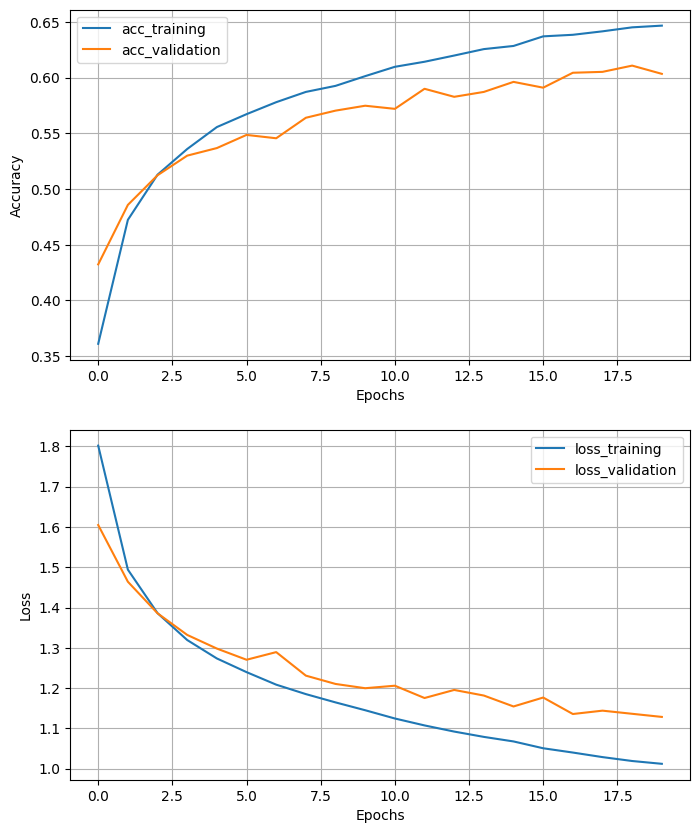

In [26]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [27]:
test(deep_model)

Test Loss: 1.08036232 ---------- Test Accuracy: 62.2800%


By developing the deep CNN we dropped the accuracy fom ~64% to ~62%. I need a better model.

In [28]:
conv_filters = [128, 64, 32]
kernel_sizes = [[5, 5], [3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2], [2, 2]]
act_fs = [F.relu, F.relu, F.relu]

num_epochs = 30
lr = 1e-3
deep_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(deep_model, input_size=(batch_size, 3, 32, 32))

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deep_model.parameters(), lr=lr)


start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(deep_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")






epoch: 1 -> Accuracy: 35.76%, Loss: 1.77008116 ---------------- Val_Acc: 44.56%, Val_Loss: 1.55862951
epoch: 2 -> Accuracy: 49.30%, Loss: 1.42493379 ---------------- Val_Acc: 52.94%, Val_Loss: 1.35178995
epoch: 3 -> Accuracy: 54.44%, Loss: 1.28751469 ---------------- Val_Acc: 54.48%, Val_Loss: 1.28851962
epoch: 4 -> Accuracy: 57.73%, Loss: 1.20255566 ---------------- Val_Acc: 57.28%, Val_Loss: 1.20885551
epoch: 5 -> Accuracy: 60.51%, Loss: 1.12970924 ---------------- Val_Acc: 60.46%, Val_Loss: 1.14557946
epoch: 6 -> Accuracy: 61.91%, Loss: 1.08451891 ---------------- Val_Acc: 60.32%, Val_Loss: 1.14792192
epoch: 7 -> Accuracy: 63.77%, Loss: 1.03436971 ---------------- Val_Acc: 62.50%, Val_Loss: 1.07867467
epoch: 8 -> Accuracy: 64.88%, Loss: 1.00732863 ---------------- Val_Acc: 61.78%, Val_Loss: 1.09874380
epoch: 9 -> Accuracy: 66.12%, Loss: 0.97019434 ---------------- Val_Acc: 62.54%, Val_Loss: 1.07665861
epoch: 10 -> Accuracy: 67.43%, Loss: 0.93902504 ---------------- Val_Acc: 64.46%, 

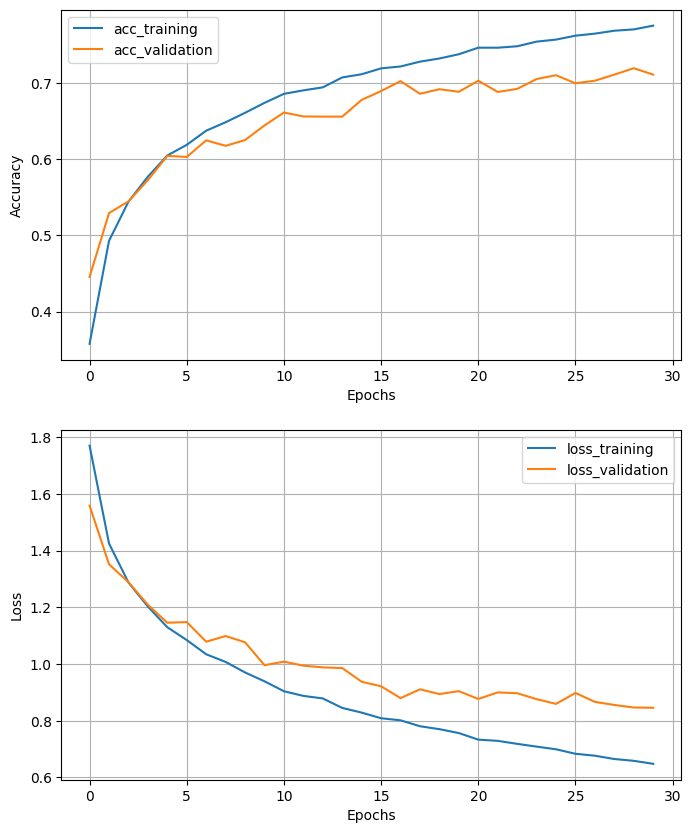

In [29]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [30]:
test(deep_model)

Test Loss: 0.85082811 ---------- Test Accuracy: 71.3300%


# Transfer Learning with ResNet18 + ImageNet

Let's now experiment with transfer learning. I will now load the model structure and weights of a small [ResNet], pretrained on the ImageNet dataset. I will then add a fully connected layer at the end of the network and fine-tune it on the CIFAR10 dataset.

In [31]:
from torchvision.models import resnet18, ResNet18_Weights

In [32]:
RESNET18 = resnet18(pretrained=True)
summary(RESNET18, input_size=(batch_size, 3, 32, 32))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [256, 1000]               --
├─Conv2d: 1-1                            [256, 64, 16, 16]         9,408
├─BatchNorm2d: 1-2                       [256, 64, 16, 16]         128
├─ReLU: 1-3                              [256, 64, 16, 16]         --
├─MaxPool2d: 1-4                         [256, 64, 8, 8]           --
├─Sequential: 1-5                        [256, 64, 8, 8]           --
│    └─BasicBlock: 2-1                   [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-1                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-2             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-3                    [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-5             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-6                    [256, 64, 8, 8]           --
│

The ResNet has a final fully connected layer that generates 1000 logits corresponding to the classes in the ImageNet dataset. I will re-define it and make it map the features learned in the previous layer to the 10 classes of the CIFAR10 datset.

In [33]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 1000


In [34]:
# Replace  the last layer
RESNET18.fc = Linear(linear_layer_input, 10)

In [35]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 10


In [36]:
for name, param in RESNET18.named_parameters():
    if name == 'fc.weight' or name == 'fc.bias':
      param.requires_grad = True
    else:
      param.requires_grad = False

In [37]:
RESNET18 = RESNET18.to(device) # Let's now load it to GPU

Let's consider a smaller subset of CIFAR10 in order to speed-up the fine-tuning process:

In [38]:
train_idxs = list(range(0, len(train_data), 5))  # 45000/5=9000 Tr
val_idxs = list(range(1, len(val_data), 5))  # 5000/5=1000 Val
test_idxs = list(range(1, len(test_data), 5))  # 10000/5=2000 Ts

train_data_sub = torch.utils.data.Subset(train_data, train_idxs)
val_data_sub = torch.utils.data.Subset(val_data, val_idxs)
test_data_sub = torch.utils.data.Subset(test_data, test_idxs)

In order to apply custom preprocessing steps that are expected by the pretrained model, we will define a small wrapper around the CIFAR10 dataset.

In [39]:
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

class RESDatasetWrapper(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    image, label = self.dataset[idx]
    image = preprocess(image)
    label = torch.tensor(label, dtype=torch.long)
    return image.to(device), label.to(device)

In [40]:
RES_train_dataset = RESDatasetWrapper(train_data_sub)
RES_val_dataset = RESDatasetWrapper(val_data_sub)
RES_test_dataset = RESDatasetWrapper(test_data_sub)

batch_size=256

RES_dataloader_training = DataLoader(RES_train_dataset, batch_size=batch_size, shuffle=True)
RES_dataloader_validation = DataLoader(RES_val_dataset, batch_size=batch_size)
RES_dataloader_test = DataLoader(RES_test_dataset, batch_size=batch_size)

In [41]:
num_epochs = 10
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RESNET18.parameters(), lr=lr)

In [42]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(RESNET18, optimizer, RES_dataloader_training, RES_dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 38.68%, Loss: 1.86945915 ---------------- Val_Acc: 60.30%, Val_Loss: 1.41788054
epoch: 2 -> Accuracy: 66.79%, Loss: 1.18987119 ---------------- Val_Acc: 67.10%, Val_Loss: 1.09615588
epoch: 3 -> Accuracy: 71.44%, Loss: 0.97522134 ---------------- Val_Acc: 69.10%, Val_Loss: 0.97041428
epoch: 4 -> Accuracy: 73.13%, Loss: 0.87385738 ---------------- Val_Acc: 70.00%, Val_Loss: 0.89962500
epoch: 5 -> Accuracy: 74.61%, Loss: 0.81311029 ---------------- Val_Acc: 70.90%, Val_Loss: 0.86146486
epoch: 6 -> Accuracy: 75.71%, Loss: 0.77008551 ---------------- Val_Acc: 71.50%, Val_Loss: 0.81924284
epoch: 7 -> Accuracy: 76.14%, Loss: 0.74313414 ---------------- Val_Acc: 71.90%, Val_Loss: 0.79732215
epoch: 8 -> Accuracy: 76.86%, Loss: 0.71303093 ---------------- Val_Acc: 71.70%, Val_Loss: 0.78576148
epoch: 9 -> Accuracy: 77.08%, Loss: 0.68935841 ---------------- Val_Acc: 72.60%, Val_Loss: 0.77678198
epoch: 10 -> Accuracy: 78.19%, Loss: 0.67134529 ---------------- Val_Acc: 72.50%, 

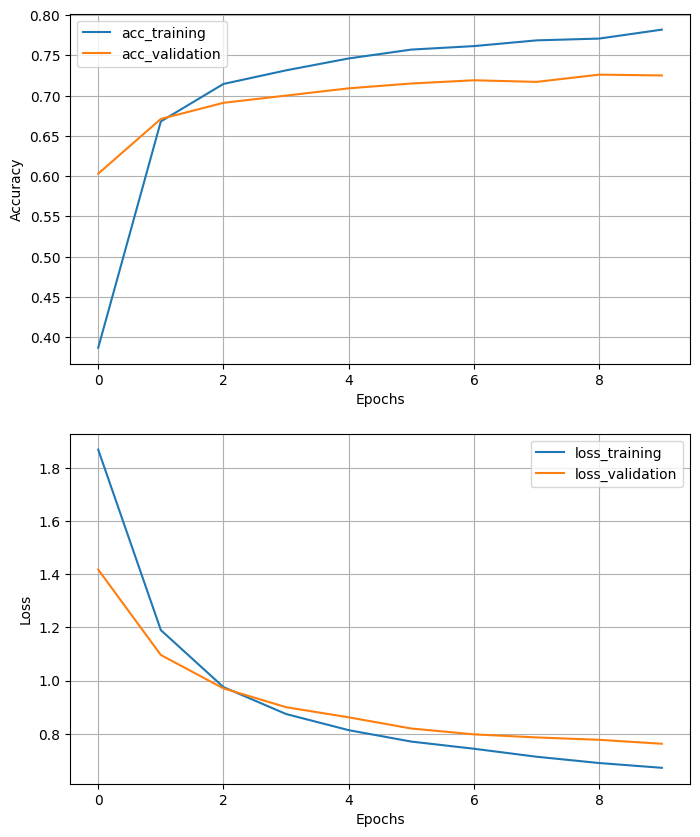

In [43]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [44]:
test(RESNET18, dataloader_test=RES_dataloader_test)

Test Loss: 0.75668716 ---------- Test Accuracy: 73.6000%


I got this result by leveraging a model freely available on the internet and trained on another dataset. That's the advantage of transfer learning.